In [ ]:
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm


In [2]:
dataset_directory ="/content/drive/MyDrive/Assignment 1/Animals"

Processing Tiger: 100%|██████████| 39/39 [00:00<00:00, 96.86it/s]


Dataset loaded with 170 images across 5 categories.


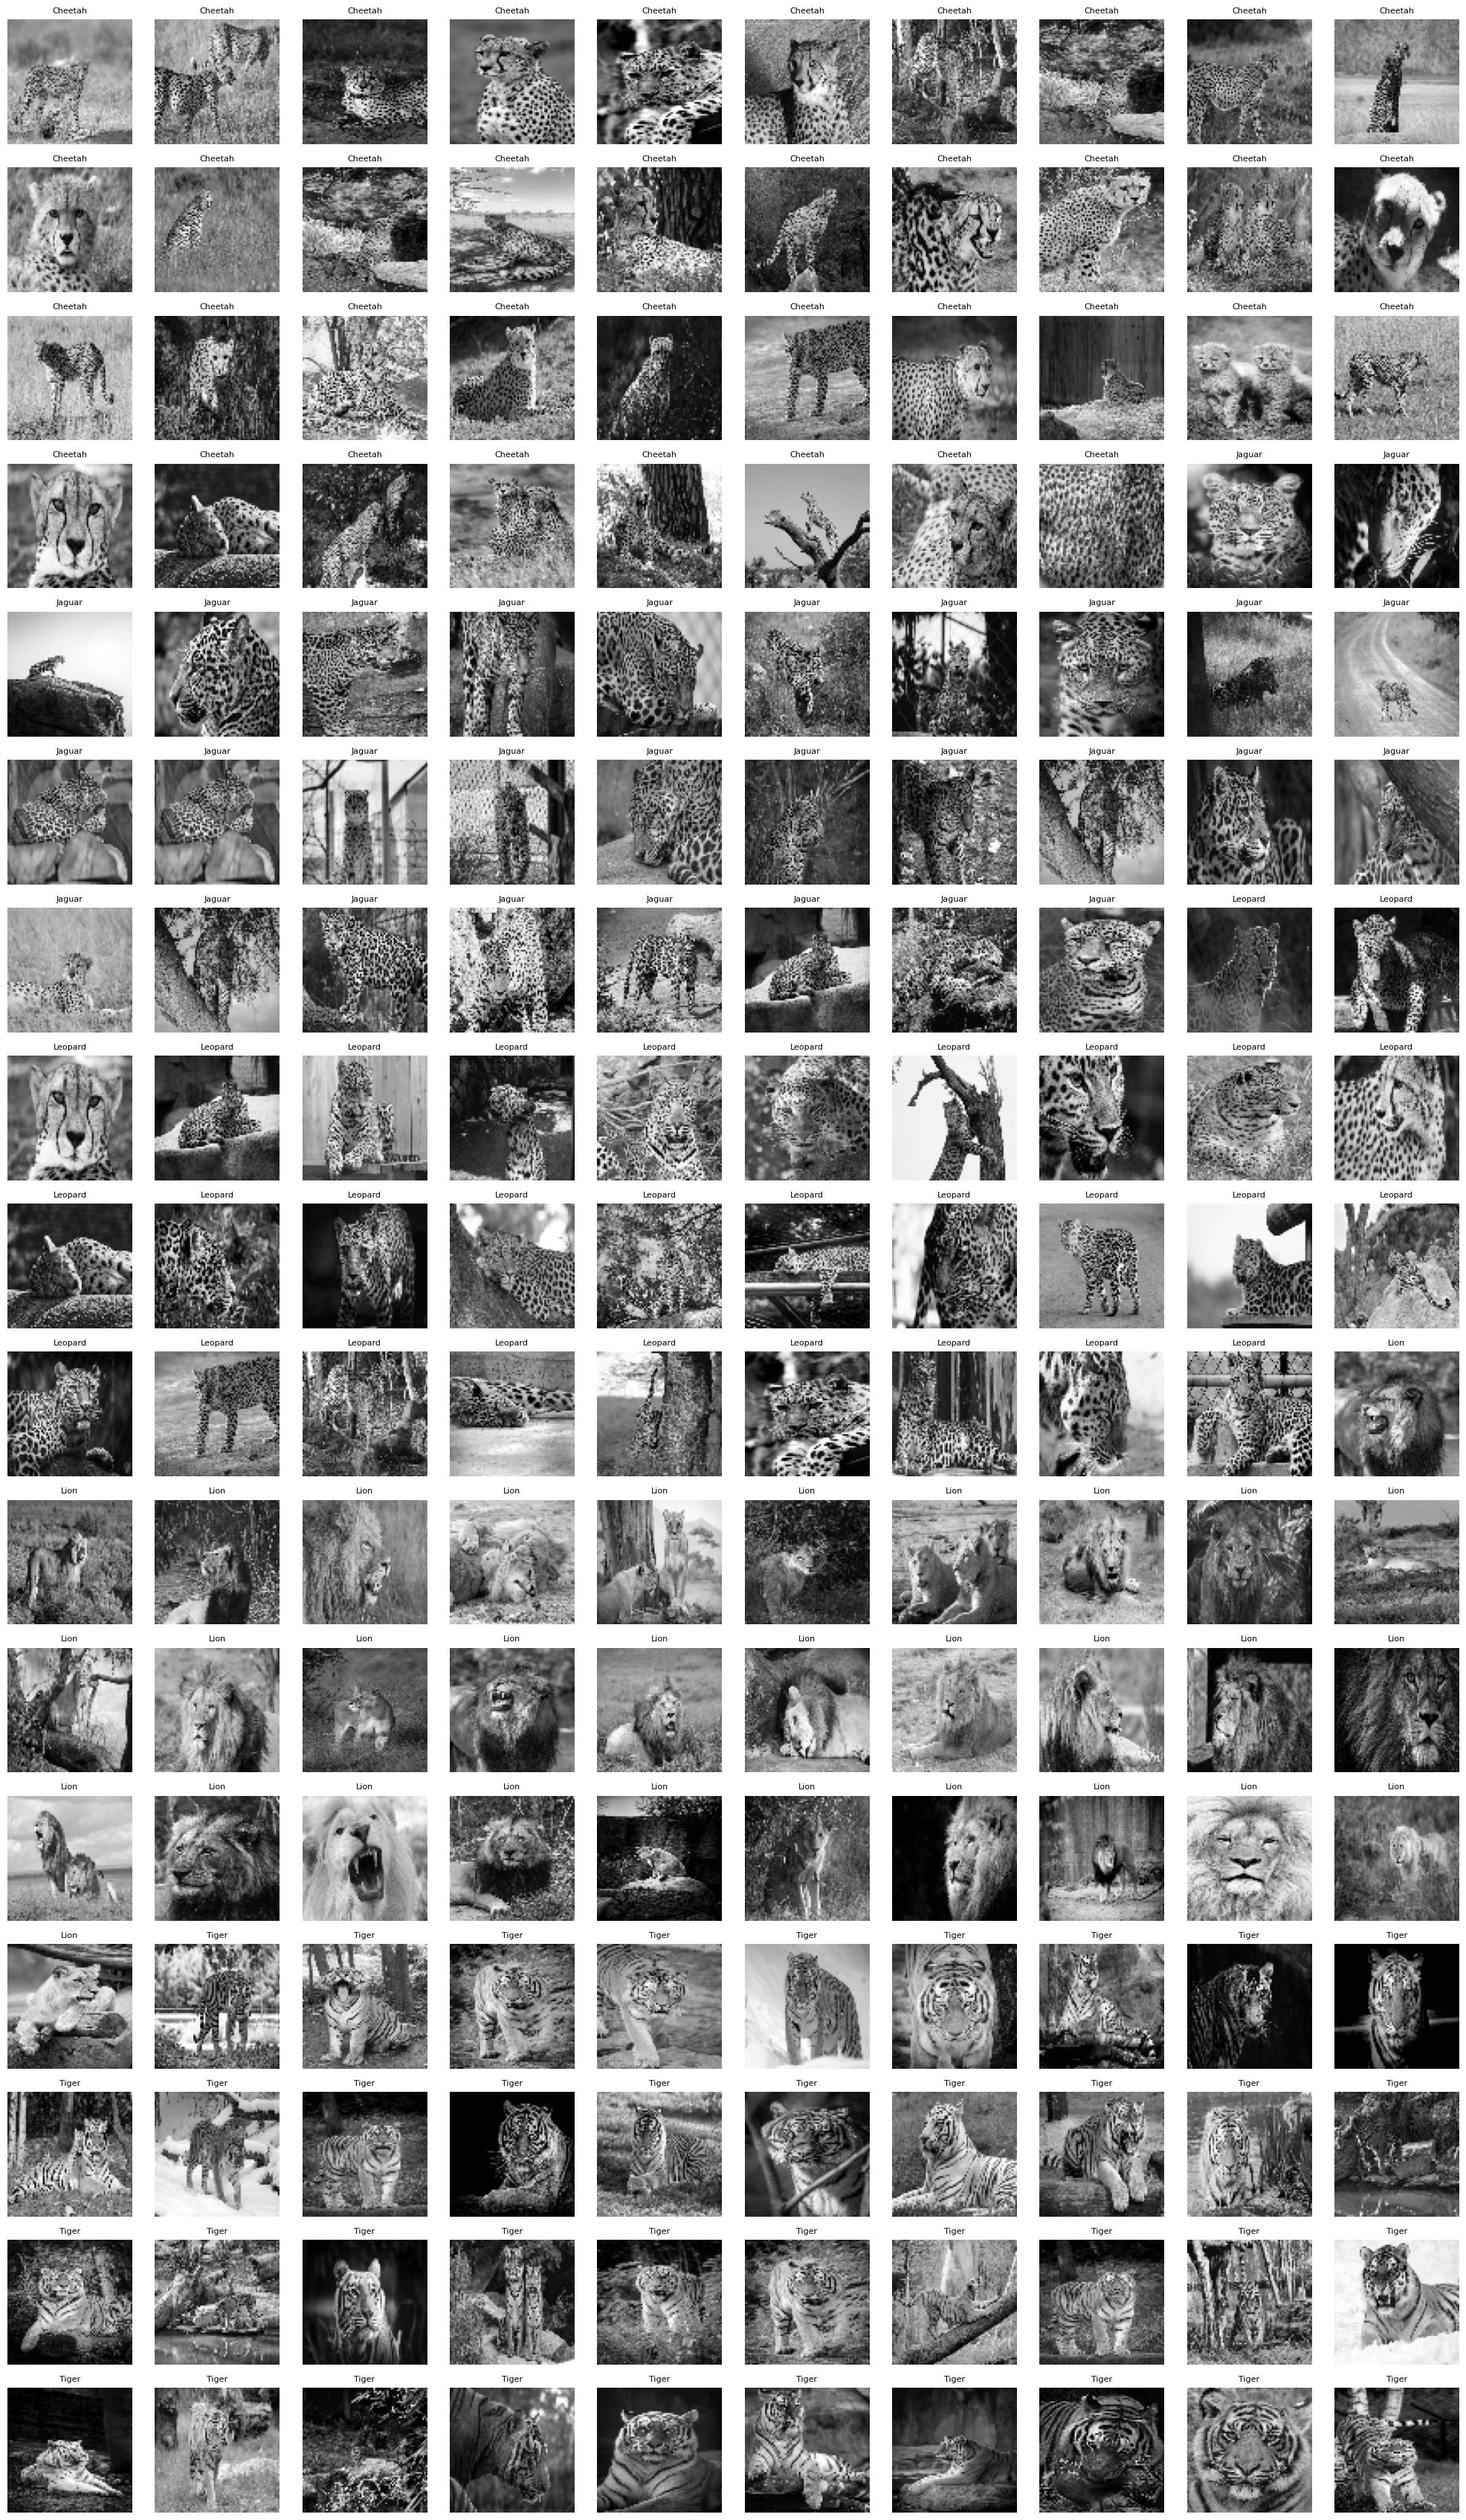

In [11]:
# Animal categories (subfolders)
animal_classes = ["Cheetah", "Jaguar", "Leopard", "Lion", "Tiger"]

# Function to load images and labels
def process_dataset():
    data_images = []
    data_labels = []
    for category in animal_classes:
        folder_path = os.path.join(dataset_directory, category)
        for image_file in tqdm(os.listdir(folder_path), desc=f"Processing {category}"):
            full_image_path = os.path.join(folder_path, image_file)
            if os.path.isfile(full_image_path):
                img = cv2.imread(full_image_path)
                if img is not None:
                    resized_img = cv2.resize(img, (74, 74))
                    grayscale_img = cv2.cvtColor(resized_img, cv2.COLOR_BGR2GRAY)
                    data_images.append(grayscale_img)
                    data_labels.append(category)
    return np.array(data_images), np.array(data_labels)

# Load dataset
images_data, labels_data = process_dataset()
print(f"Dataset loaded with {len(images_data)} images across {len(animal_classes)} categories.")

# Function to display images (170 in this case)
def show_sample_images(image_set, label_set, sample_count=170):
    # Calculate rows and columns for better layout
    columns = 10  # Number of images per row
    rows = (sample_count + columns - 1) // columns  # Total rows needed

    # Adjust figure size dynamically
    plt.figure(figsize=(20, rows * 2))

    # Display the images
    for idx in range(min(sample_count, len(image_set))):
        plt.subplot(rows, columns, idx + 1)
        plt.imshow(image_set[idx], cmap='gray')
        plt.title(label_set[idx], fontsize=8)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Call the function to display 170 images
show_sample_images(images_data, labels_data, sample_count=170)

In [6]:
# Function to calculate Euclidean distance
def compute_l2_distance(image_a, image_b):
    return np.linalg.norm(image_a - image_b)

In [7]:
def k_nearest_neighbor(test_img, train_imgs, train_lbls, num_neighbors):
    distance_label_pairs = []
    for idx in range(len(train_imgs)):
        dist = compute_l2_distance(test_img, train_imgs[idx])
        distance_label_pairs.append((dist, train_lbls[idx]))

    # Sort distances and fetch the nearest neighbors
    distance_label_pairs.sort(key=lambda pair: pair[0])
    nearest_labels = [label for _, label in distance_label_pairs[:num_neighbors]]

    # Determine the most frequent label
    label_counts = {label: nearest_labels.count(label) for label in nearest_labels}
    return max(label_counts, key=label_counts.get)

In [8]:
def split_into_folds(data_images, data_labels, num_folds=5):
    indices = np.arange(len(data_images))
    np.random.shuffle(indices)
    fold_size = len(data_images) // num_folds

    for fold_idx in range(num_folds):
        test_idx = indices[fold_idx * fold_size : (fold_idx + 1) * fold_size]
        train_idx = np.concatenate([indices[:fold_idx * fold_size], indices[(fold_idx + 1) * fold_size:]])
        yield data_images[train_idx], data_images[test_idx], data_labels[train_idx], data_labels[test_idx]


In [9]:
# Define range of K values
neighbor_range = range(1, 31)
fold_accuracies = {k: [] for k in neighbor_range}

# Perform 5-fold cross-validation
for train_imgs, test_imgs, train_lbls, test_lbls in split_into_folds(images_data, labels_data):
    for k in tqdm(neighbor_range, desc="Evaluating k-NN"):
        correct_predictions = 0
        for idx in range(len(test_imgs)):
            prediction = k_nearest_neighbor(test_imgs[idx], train_imgs, train_lbls, k)
            if prediction == test_lbls[idx]:
                correct_predictions += 1
        accuracy = correct_predictions / len(test_imgs)
        fold_accuracies[k].append(accuracy)

# Calculate average accuracy for each K
average_accuracies = {k: np.mean(scores) for k, scores in fold_accuracies.items()}

Evaluating k-NN: 100%|██████████| 30/30 [00:02<00:00, 11.25it/s]


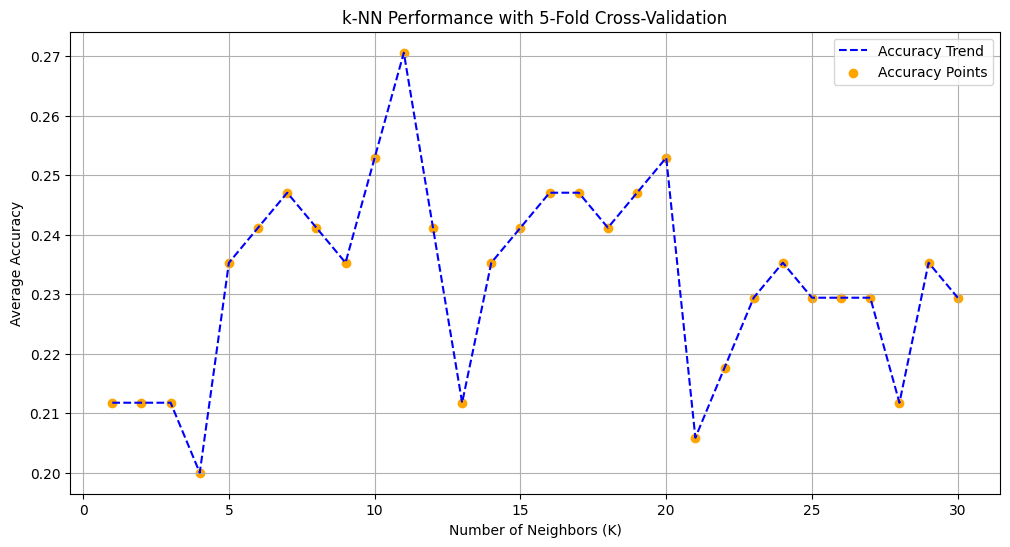

In [10]:
# Extract data for plotting
k_values = list(average_accuracies.keys())
accuracy_values = list(average_accuracies.values())

# Plotting the results
plt.figure(figsize=(12, 6))
plt.plot(k_values, accuracy_values, label='Accuracy Trend', color='blue', linestyle='--')
plt.scatter(k_values, accuracy_values, color='orange', label='Accuracy Points')
plt.xlabel("Number of Neighbors (K)")
plt.ylabel("Average Accuracy")
plt.title("k-NN Performance with 5-Fold Cross-Validation")
plt.legend()
plt.grid(True)
plt.show()